In [22]:
from itertools import chain, repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb


from hp_pred.experiments import bootstrap_test, load_labelized_cases, print_statistics



## Load and format data

In [23]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/chu_dataset/cases/'))
data['label_id'] = data['label_id'].astype(str) + "_" + data['caseid'].astype(str)

static = pd.read_parquet('data/datasets/chu_dataset/meta.parquet')



data = data.merge(static, on='caseid')

test = data

SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa"]
HALF_TIME_FILTERING = [60, 3*60, 10*60]

FEATURE_NAME = (
    [
        f"{signal}_constant_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_slope_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)

FEATURE_NAME = [x for x in FEATURE_NAME if "std_30" not in x]


test = test.dropna(subset=FEATURE_NAME)


In [24]:
test.caseid.isin(abnormal_caseid)

1337     True
1338     True
1339     True
1340     True
1341     True
         ... 
71702    True
71703    True
71704    True
71705    True
71706    True
Name: caseid, Length: 69683, dtype: bool

In [25]:
# Remove abnormal cases with the regards to the training set

abnormal_caseid =['1', '2', '7', '8', '9', '10', '11', '15', '17', '23', '24', '25', '35', '37', '42',
 '44', '51', '53', '57', '62', '70', '73', '78', '92', '94', '97', '98', '103', '107',
 '109', '120', '126', '128', '137', '143', '144', '146', '148', '149', '156', '162',
 '165', '167', '174', '177', '178', '188', '190', '191', '193', '194', '199', '200',
 '203', '215', '216', '217', '222', '227', '232', '236', '240', '246', '247', '249',
 '251', '261', '262', '274', '277', '293', '299', '305', '313', '314', '315', '320',
 '322', '328', '330', '342', '345', '348', '352', '353', '358', '362', '366', '368',
 '373', '374', '384', '385', '388', '397', '399', '400', '406', '420', '427', '431',
 '437', '446', '447', '454', '457', '460', '461', '468', '470', '474', '480', '482',
 '485', '488', '493', '501', '502', '510', '512', '517', '518', '524', '531', '532',
 '540', '541', '544', '547', '550', '559', '560', '568', '573', '576', '583', '587',
 '588']


# abnormal_caseid = [int(el) for el in abnormal_caseid]
print(len(test))
test = test[~(test.caseid.isin(abnormal_caseid))]
print(len(test))

69683
50015


## Test the baseline

In [26]:
# for each subgoup of data, create a regressor and evaluate it
n_bootstraps = 200
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)

FEATURE_NAME_BASELINE = "last_map_value"

# create a regressor
print(f"test set contains {len(test)} sample with a prevalence of {test['label'].mean()*100:.2f}% ")
test = test.dropna(subset=[FEATURE_NAME_BASELINE])

x_test = test[FEATURE_NAME_BASELINE].values
y_test = test['label'].values
y_pred = 1 - x_test/120
y_label_id = test["label_id"].values


df_results, tpr_list, precision_interpolated = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=n_bootstraps, rng_seed=rng_seed, strategy='fixed_threshold', target=0.443) 

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.mkdir()
roc_results = result_folder / "chu_baseline_results.csv"
df_results.to_csv(roc_results, index=False)

test set contains 50015 sample with a prevalence of 22.57% 


100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


## Train or load existing model


In [27]:
# control reproducibility
rng_seed = 42

test = test.dropna(subset=FEATURE_NAME)
print(
    f"{len(test):,d} test samples, "
    f"{test['label'].mean():.2%} positive rate."
)

# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / "xgb_30_s.json"

if model_file.exists():
    model = xgb.XGBClassifier()
    model.load_model(model_file)
else:
    print("Model file not found, training model.")

50,015 test samples, 22.57% positive rate.


## Evaluation

### Model's prediction variance

#### Variance estimation by bootstrapping

In [28]:
y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
y_test = test["label"].to_numpy()
y_label_ids = test["label_id"].to_numpy()

df_results, tprs_interpolated, precision_interpolated = bootstrap_test(y_test, y_pred, y_label_ids, n_bootstraps=200, rng_seed=rng_seed, strategy='fixed_threshold', target=0.180) 

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "chu_xgboost_results.csv"
df_results.to_csv(roc_results, index=False)


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Print main statistics

In [29]:
print('Baseline')
df_baseline = pd.read_csv("data/results/chu_baseline_results.csv")
print_statistics(df_baseline)

print('\n')
print('XGBoost')

print_statistics(df_results)

Baseline
AUC: 66.7% ± 0.3%
AP: 34.5% ± 0.4%
AUPRC: 38.0% ± 0.6%
Threshold: 0.44 ± 0.00
Recall: 19.6% ± 0.6%
Precision: 41.1% ± 1.2%
Specificity: 85.7% ± 0.8%
NPV: 97.9% ± 0.0%
F1-score: 0.27 ± 0.01


XGBoost
AUC: 69.7% ± 0.3%
AP: 35.8% ± 0.4%
AUPRC: 38.9% ± 0.6%
Threshold: 0.18 ± 0.00
Recall: 66.0% ± 0.7%
Precision: 39.5% ± 0.5%
Specificity: 95.0% ± 0.1%
NPV: 99.2% ± 0.0%
F1-score: 0.49 ± 0.00


### Plot

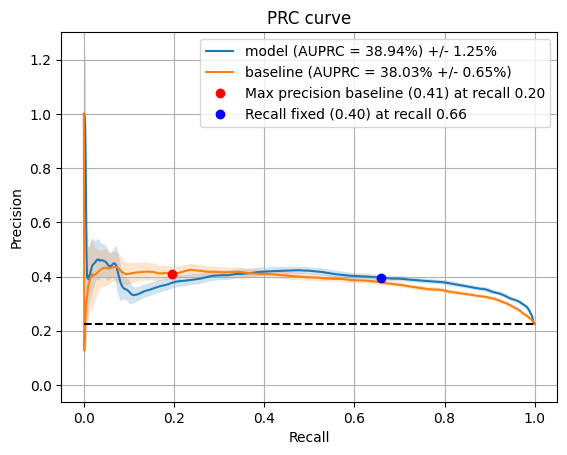

In [30]:
recall = np.linspace(0, 1, 1000)

precision_mean, precision_std = df_results.precision.to_numpy(), df_results.precision_std.to_numpy()
auprc_mean, auprc_std = df_results.auprc[0], df_results.auprc_std[0]
plt.fill_between(
    recall, precision_mean - 2 * precision_std, precision_mean + 2 * precision_std, alpha=0.2
)
plt.plot(recall, precision_mean, label=f"model (AUPRC = {auprc_mean:.2%}) +/- {2*auprc_std:.2%}")

# add baseline to the plot
plt.fill_between(
    df_baseline.recall,
    df_baseline.precision - 2 * df_baseline.precision_std,
    df_baseline.precision + 2 * df_baseline.precision_std,
    alpha=0.2,
)
plt.plot(
    df_baseline.recall.values,
    df_baseline.precision.values,
    label=f"baseline (AUPRC = {df_baseline.auprc[0]:.2%} +/- {df_baseline.auprc_std[0]:.2%})",
)

plt.plot([df_baseline['recall_threshold'].iloc[-1]], [df_baseline['precision_threshold'].iloc[-1]], 'ro', label=f"Max precision baseline ({df_baseline['precision_threshold'].iloc[-1]:.2f}) at recall {df_baseline['recall_threshold'].iloc[-1]:.2f}")
plt.plot([df_results['recall_threshold'].iloc[-1]], [df_results['precision_threshold'].iloc[-1]], 'bo', label=f"Recall fixed ({df_results['precision_threshold'].iloc[-1]:.2f}) at recall {df_results['recall_threshold'].iloc[-1]:.2f}")


plt.plot([0, 1], [df_results['precision'].iloc[-1]]*2, "k--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC curve")
plt.legend()
plt.grid()
plt.show()

## SHAP interpretations

In [31]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 10

model = xgb.Booster()
model.load_model(model_file)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[FEATURE_NAME])
test_data = data[FEATURE_NAME]


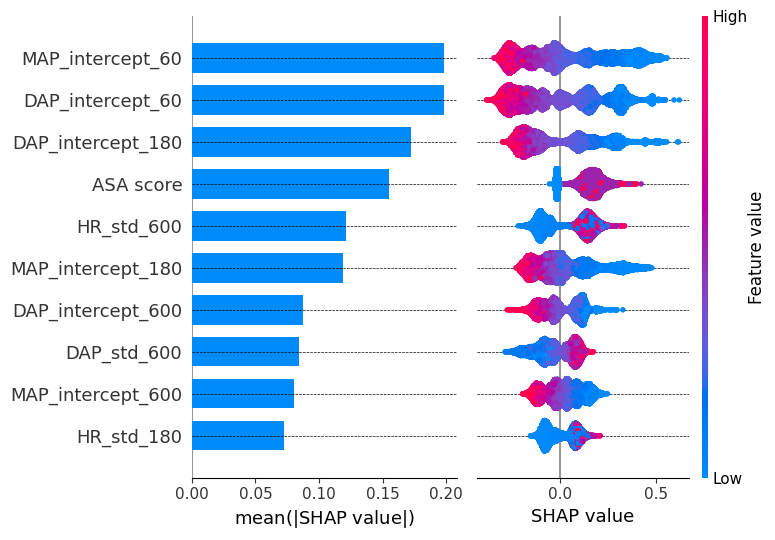

In [32]:
# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean($|$SHAP value$|$)')
names = [   'MAP_intercept_60',
            'DAP_intercept_60',
            'DAP_intercept_180',
            'ASA score',
            'HR_std_600',
            'MAP_intercept_180',
            'DAP_intercept_600',
            'DAP_std_600',
            'MAP_intercept_600',
            'HR_std_180',
            ]
names.reverse()
plt.gca().set_yticklabels(names)
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.savefig('./output/shap_xgboost_chu.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [33]:
# Helper grouping function
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

In [34]:
# Group features
feature_group = {
    'MAP_ema': [name for name in FEATURE_NAME if 'mbp_ema' in name],
    'MAP_std': [name for name in FEATURE_NAME if 'mbp_std' in name],
    'DAP_ema': [name for name in FEATURE_NAME if 'dbp_ema' in name],
    'DAP_std': [name for name in FEATURE_NAME if 'dbp_std' in name],
    'SAP_ema': [name for name in FEATURE_NAME if 'sbp_ema' in name],
    'SAP_std': [name for name in FEATURE_NAME if 'sbp_std' in name],
    'MAC_ema': [name for name in FEATURE_NAME if 'mac_ema' in name],
    'MAC_std': [name for name in FEATURE_NAME if 'mac_std' in name],
    'HR_ema': [name for name in FEATURE_NAME if 'hr_ema' in name],
    'HR_std': [name for name in FEATURE_NAME if 'hr_std' in name],
    'RR_ema': [name for name in FEATURE_NAME if 'rr_ema' in name],
    'RR_std': [name for name in FEATURE_NAME if 'rr_std' in name],
    'SPO2_ema': [name for name in FEATURE_NAME if 'spo2_ema' in name],
    'SPO2_std': [name for name in FEATURE_NAME if 'spo2_std' in name],
    'ETCO2_ema': [name for name in FEATURE_NAME if 'etco2_ema' in name],
    'ETCO2_std': [name for name in FEATURE_NAME if 'etco2_std' in name],
    'PROPO_ema': [name for name in FEATURE_NAME if 'pp_ct_ema' in name],
    'PROPO_std': [name for name in FEATURE_NAME if 'pp_ct_std' in name],
    'AGE': ['age'],
    'BMI': ['bmi'],
    'ASA': ['asa'],
    'PREOP_CR': ['preop_cr'],
    'PREOP_HTN': ['preop_htn'],
}


shap_group = grouped_shap(shap_values, FEATURE_NAME, feature_group)
test_data_group = grouped_shap(test_data, FEATURE_NAME, feature_group)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


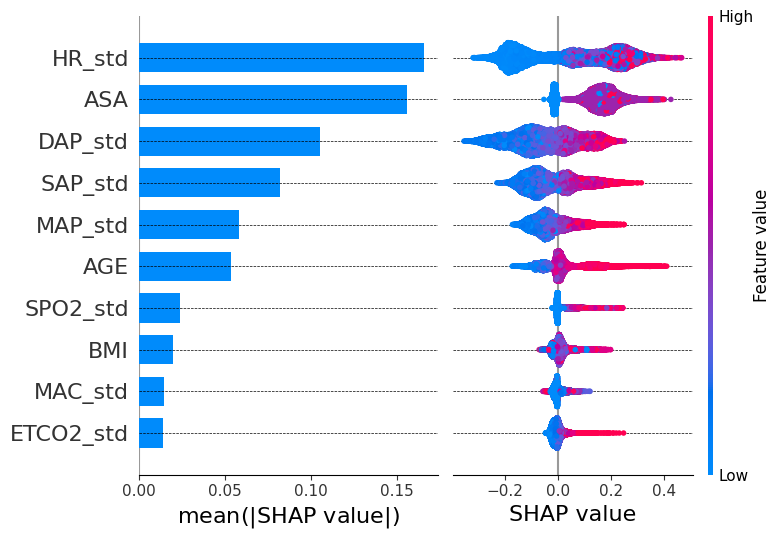

In [35]:
# plot the grouped SHAP value
font_size = 16

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_group, test_data_group, feature_names=shap_group.columns, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean($|$SHAP value$|$)', fontsize=font_size)
ax = plt.gca()
ax.tick_params(axis='y', labelsize=font_size)

plt.subplot(1, 2, 2)
shap.summary_plot(shap_group.values, test_data_group, feature_names=shap_group.columns, max_display=nb_max_feature, show=False)
plt.xlabel('SHAP value', fontsize=font_size)
#remove the y thick label
ax = plt.gca()
ax.set_yticklabels([])
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./output/shap_xgboost_group_chu.pdf', bbox_inches='tight', dpi=600)
plt.show()

## exemple of cases


In [36]:
# plot 3 random cases with the corresponding decision function

np.random.seed(12)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)
model = xgb.Booster()
model.load_model(model_file)
for case in cases:
    raw_case = load_labelized_cases(dataset_path=Path('data/datasets/chu_dataset_no_leading_time/'), caseid=int(case))

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=FEATURE_NAME)
    x_test = segment_data[FEATURE_NAME]
    y_pred = model.predict(xgb.DMatrix(x_test))

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds /60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    # FIXME: raw_case.mbp might be NaN. fillna(0) ?
    plt.plot(raw_case.index.seconds /60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')

    #plot in red point labeled as IOH
    plt.plot(segment_data[segment_data.label>0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label>0]*100, 'r.', label='model decision function')
    plt.plot(segment_data[segment_data.label==0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label==0]*100, 'g.', label='model decision function')


    # plt.plot(segment_data.time / np.timedelta64(1, 's') /60,segment_data.time_before_IOH, 'x', label='model decision function')

    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([0, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()




FileNotFoundError: [Errno 2] No such file or directory: 'data/datasets/chu_dataset_no_leading_time/DatasetBuilder_parameters.json'